In [1]:
import cv2
import matplotlib.pyplot as plt
import os
import numpy as np
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dense,Flatten, Dropout, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.layers import RandomContrast
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
import tensorflow_hub as hub
from tensorflow.keras.applications import DenseNet201

2023-11-18 20:01:59.537752: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-18 20:01:59.682567: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-18 20:01:59.683781: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-18 20:02:00.652961: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
#inputs
#dimensions of the images
h=224
d=224
#########
dog=[1,0]
cat=[0,1]

In [3]:
dog_images=[]

dir = '/home/sourav/Downloads/img/train/dogs'

for files in os.listdir(dir):
    dog_images.append(files)

def func_image_reading_reshape(image_list, animal):
    empty_list1=[]
    empty_list2=[]
    for image in image_list:
        image=os.path.join(dir,image)
        image=cv2.imread(image)
        image=cv2.resize(image,(h,d))
        empty_list1.append(image)
        out=animal
        empty_list2.append(out)
    return empty_list1, empty_list2


inp1_tensor, out1_tensor= func_image_reading_reshape(dog_images,dog)

cats_images=[]

dir = '/home/sourav/Downloads/img/train/cats'

for files in os.listdir(dir):
    cats_images.append(files)   

inp2_tensor, out2_tensor= func_image_reading_reshape(cats_images,cat)

inp_tensor=inp1_tensor + inp2_tensor
out_tensor=out1_tensor + out2_tensor

In [4]:
inp_tensor=np.array(inp_tensor)
out_tensor=np.array(out_tensor)

print(inp_tensor.shape)
print(out_tensor.shape)

(557, 224, 224, 3)
(557, 2)


### Normalization of inp_tensor

In [5]:
mean=[]
min=[]
max=[]
for i in range(3):
    mean.append(np.mean(inp_tensor[:,:,:,i]))
    min.append(np.min(inp_tensor[:,:,:,i]))
    max.append(np.max(inp_tensor[:,:,:,i]))

norm_inp=np.zeros((len(inp_tensor),h,d,3))

for i in range(len(inp_tensor)):
    for j in range(h):
        for m in range(d):
            for n in range(3):
               norm_inp[i,j,m,n] =(inp_tensor[i,j,m,n]-mean[n])/max[n] -min[n]

norm_inp.shape

(557, 224, 224, 3)

### Random shuffle of list index

In [6]:
import random

my_list=[]
random.seed(0)

for m in range(len(inp_tensor)):
    my_list.append(m)

shuffled_list = random.sample(my_list, len(my_list))

In [7]:
inp_shuffel=[]
oup_shuffel=[]
for idx in shuffled_list:
    inp_shuffel.append(norm_inp[idx])
    oup_shuffel.append(out_tensor[idx])

inp_shuffel=np.array(inp_shuffel)
oup_shuffel=np.array(oup_shuffel)


print(inp_shuffel.shape)
oup_shuffel.shape

(557, 224, 224, 3)


(557, 2)

### Validation Set

In [8]:
dog_images=[]

dir = '/home/sourav/Downloads/img/test/dogs'

for files in os.listdir(dir):
    dog_images.append(files)   

X_test, Y_test= func_image_reading_reshape(dog_images,dog)

cat_images=[]

dir = '/home/sourav/Downloads/img/test/cats'

for files in os.listdir(dir):
    cat_images.append(files) 

X1_test, Y1_test= func_image_reading_reshape(cat_images,cat)

X_val=X_test+ X1_test
Y_val=Y_test+ Y1_test

X_val=np.array(X_val)
Y_val=np.array(Y_val)


#################################################################
#  Normalization

mean=[]
min=[]
max=[]
for i in range(3):
    mean.append(np.mean(X_val[:,:,:,i]))
    max.append(np.max(X_val[:,:,:,i]))
    min.append(np.min(X_val[:,:,:,i]))
mean

norm_Xval=np.zeros((len(X_val),h,d,3))

for i in range(len(X_val)):
    for j in range(h):
        for m in range(d):
            for n in range(3):
               norm_Xval[i,j,m,n] =(X_val[i,j,m,n]-mean[n])/max[n] -min[n]

################################################################

print(norm_Xval.shape)
print(Y_val.shape)

(140, 224, 224, 3)
(140, 2)


### Random Shuffel of the Validation Set

In [9]:
import random

my_list=[]
random.seed(0)

for m in range(len(X_val)):
    my_list.append(m)

shuffled_list = random.sample(my_list, len(my_list))

Xval_shuffel=[]
Yval_shuffel=[]
for idx in shuffled_list:
    Xval_shuffel.append(norm_Xval[idx])
    Yval_shuffel.append(Y_val[idx])

Xval_shuffel=np.array(Xval_shuffel)
Yval_shuffel=np.array(Yval_shuffel)


print(Xval_shuffel.shape)
Yval_shuffel.shape

(140, 224, 224, 3)


(140, 2)

### Model Building

In [10]:
data_augmentation=Sequential()
data_augmentation.add(RandomFlip("horizontal", input_shape=(h,d,3)))
data_augmentation.add(RandomZoom(0.3))
data_augmentation.add(RandomRotation(0.1))
data_augmentation.add(RandomContrast(0.8))

In [11]:
base_model=DenseNet201(weights='imagenet', include_top=False)
base_model.trainable= True

#This is how I made last block layers trainable
for layer in base_model.layers[:-9]:
    layer.trainable= False


#This is how you can see  the layers and training status of the layers
for layer in base_model.layers:
    print(layer.name, layer.trainable)

input_1 False
zero_padding2d False
conv1/conv False
conv1/bn False
conv1/relu False
zero_padding2d_1 False
pool1 False
conv2_block1_0_bn False
conv2_block1_0_relu False
conv2_block1_1_conv False
conv2_block1_1_bn False
conv2_block1_1_relu False
conv2_block1_2_conv False
conv2_block1_concat False
conv2_block2_0_bn False
conv2_block2_0_relu False
conv2_block2_1_conv False
conv2_block2_1_bn False
conv2_block2_1_relu False
conv2_block2_2_conv False
conv2_block2_concat False
conv2_block3_0_bn False
conv2_block3_0_relu False
conv2_block3_1_conv False
conv2_block3_1_bn False
conv2_block3_1_relu False
conv2_block3_2_conv False
conv2_block3_concat False
conv2_block4_0_bn False
conv2_block4_0_relu False
conv2_block4_1_conv False
conv2_block4_1_bn False
conv2_block4_1_relu False
conv2_block4_2_conv False
conv2_block4_concat False
conv2_block5_0_bn False
conv2_block5_0_relu False
conv2_block5_1_conv False
conv2_block5_1_bn False
conv2_block5_1_relu False
conv2_block5_2_conv False
conv2_block5_conc

In [12]:
#Mobilenet-v2
#Tried but got val_accuracy ~70 %
#feature_extractor_model="https://www.kaggle.com/models/google/mobilenet-v2/frameworks/TensorFlow2/variations/035-128-classification/versions/2"
#input shape 128x128x3

#Resnet-50
#feature_extractor_model="https://www.kaggle.com/models/tensorflow/resnet-50/frameworks/TensorFlow2/variations/classification/versions/1"
#input shape 224X224x3 

#Inception_v3 (best model 86%)
#feature_extractor_model="https://www.kaggle.com/models/google/inception-v3/frameworks/TensorFlow2/variations/classification/versions/2"
#input shape 299x299


#pretrained_model=hub.KerasLayer(feature_extractor_model,trainable=False)

reg=1e-6
ker_reg=regularizers.L2(reg)

model=Sequential()

model.add(data_augmentation)

model.add(base_model)

model.add(Flatten())
model.add(Dense(64,activation='relu'))
model.add(Dense(16,activation='relu'))
model.add(Dense(2, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 densenet201 (Functional)    (None, None, None, 1920   18321984  
                             )                                   
                                                                 
 flatten (Flatten)           (None, 94080)             0         
                                                                 
 dense (Dense)               (None, 64)                6021184   
                                                                 
 dense_1 (Dense)             (None, 16)                1040      
                                                                 
 dense_2 (Dense)             (None, 2)                 34        
                                                      

In [13]:
opt=Adam(lr=0.00001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [14]:
#Useful to stop overfitting

#callbacks=[EarlyStopping(min_delta=0.001, monitor='val_accuracy', patience=5)]

model_save=[ModelCheckpoint('test-model.hd5',monitor='val_accuracy', save_best_only=True)]

Epoch 1/30
6/6 [==============================] - ETA: 0s - loss: 2.5374 - accuracy: 0.5404INFO:tensorflow:Assets written to: test-model.hd5/assets


INFO:tensorflow:Assets written to: test-model.hd5/assets


6/6 [==============================] - 94s 16s/step - loss: 2.5374 - accuracy: 0.5404 - val_loss: 1.7246 - val_accuracy: 0.5071
Epoch 2/30
6/6 [==============================] - ETA: 0s - loss: 1.2388 - accuracy: 0.6068INFO:tensorflow:Assets written to: test-model.hd5/assets


INFO:tensorflow:Assets written to: test-model.hd5/assets


6/6 [==============================] - 87s 16s/step - loss: 1.2388 - accuracy: 0.6068 - val_loss: 0.6624 - val_accuracy: 0.8143
Epoch 3/30
6/6 [==============================] - ETA: 0s - loss: 0.5481 - accuracy: 0.7594INFO:tensorflow:Assets written to: test-model.hd5/assets


INFO:tensorflow:Assets written to: test-model.hd5/assets


6/6 [==============================] - 87s 16s/step - loss: 0.5481 - accuracy: 0.7594 - val_loss: 0.1598 - val_accuracy: 0.9286
Epoch 4/30
6/6 [==============================] - 55s 9s/step - loss: 0.4566 - accuracy: 0.7702 - val_loss: 0.2241 - val_accuracy: 0.9286
Epoch 5/30
6/6 [==============================] - ETA: 0s - loss: 0.3592 - accuracy: 0.8043INFO:tensorflow:Assets written to: test-model.hd5/assets


INFO:tensorflow:Assets written to: test-model.hd5/assets


6/6 [==============================] - 87s 16s/step - loss: 0.3592 - accuracy: 0.8043 - val_loss: 0.1215 - val_accuracy: 0.9429
Epoch 6/30
6/6 [==============================] - 55s 9s/step - loss: 0.2831 - accuracy: 0.8779 - val_loss: 0.1144 - val_accuracy: 0.9429
Epoch 7/30
6/6 [==============================] - ETA: 0s - loss: 0.2552 - accuracy: 0.8959INFO:tensorflow:Assets written to: test-model.hd5/assets


INFO:tensorflow:Assets written to: test-model.hd5/assets


6/6 [==============================] - 88s 16s/step - loss: 0.2552 - accuracy: 0.8959 - val_loss: 0.1561 - val_accuracy: 0.9500
Epoch 8/30
6/6 [==============================] - ETA: 0s - loss: 0.2597 - accuracy: 0.8851INFO:tensorflow:Assets written to: test-model.hd5/assets


INFO:tensorflow:Assets written to: test-model.hd5/assets


6/6 [==============================] - 88s 16s/step - loss: 0.2597 - accuracy: 0.8851 - val_loss: 0.1385 - val_accuracy: 0.9571
Epoch 9/30
6/6 [==============================] - 56s 9s/step - loss: 0.3185 - accuracy: 0.8456 - val_loss: 0.2819 - val_accuracy: 0.9143
Epoch 10/30
6/6 [==============================] - 56s 9s/step - loss: 0.1932 - accuracy: 0.9246 - val_loss: 0.1538 - val_accuracy: 0.9500
Epoch 11/30
6/6 [==============================] - 56s 10s/step - loss: 0.1975 - accuracy: 0.9192 - val_loss: 0.2406 - val_accuracy: 0.9429
Epoch 12/30
6/6 [==============================] - 56s 10s/step - loss: 0.1846 - accuracy: 0.9156 - val_loss: 0.3313 - val_accuracy: 0.9214
Epoch 13/30
6/6 [==============================] - 53s 9s/step - loss: 0.2131 - accuracy: 0.8995 - val_loss: 0.5013 - val_accuracy: 0.8929
Epoch 14/30
6/6 [==============================] - 53s 9s/step - loss: 0.1618 - accuracy: 0.9228 - val_loss: 0.6792 - val_accuracy: 0.8500
Epoch 15/30
6/6 [====================

Text(0, 0.5, 'Accuracy')

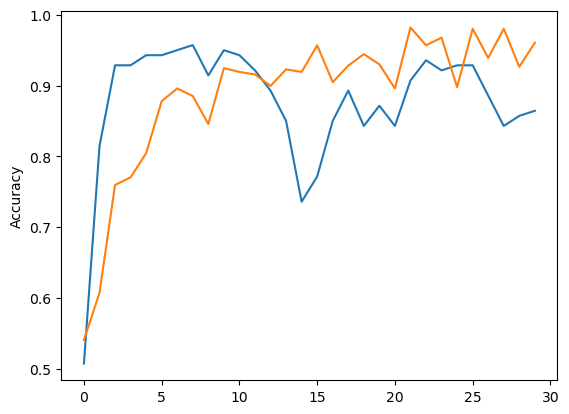

In [15]:
his=model.fit(inp_shuffel,oup_shuffel,batch_size=100, validation_data=(Xval_shuffel,Yval_shuffel), epochs=30, callbacks=model_save)
val_accuracy=his.history['val_accuracy']
training_accuracy=his.history['accuracy']

plt.plot(val_accuracy, label='Test')
plt.plot(training_accuracy, label='Training')
plt.ylabel('Accuracy')

model.save('best_model.hd5')

In [16]:
#Useful to stop overfitting

#callbacks=[EarlyStopping(monitor='val_accuracy', patience=5)]

In [21]:
model=load_model('test-model.hd5')

### Prediction using the model

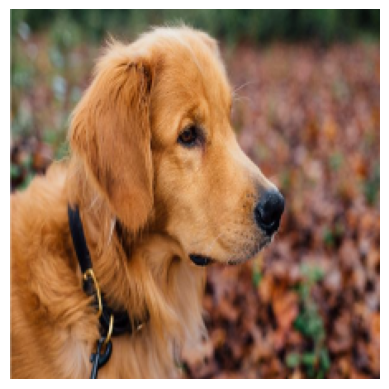

In [22]:
image='/home/sourav/Pictures/Screenshots/image3.png'


image=cv2.imread(image)
image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
image=cv2.resize(image,(h,d))
plt.imshow(image)
plt.axis('Off')


#########################Normalization
mean=[]
max=[]
min=[]
for i in range(3):
    mean.append(np.mean(image[:,:,i]))
    max.append(np.max(image[:,:,i]))
    min.append(np.min(image[:,:,i]))


norm_Xpred=np.zeros((h,d,3))

for j in range(h):
    for m in range(d):
        for n in range(3):
            norm_Xpred[j,m,n] =(image[j,m,n]-mean[n])/max[n] -min[n]

################################################################

### Data Augmentation check

data_augmentation=Sequential()
data_augmentation.add(RandomFlip("horizontal"))
data_augmentation.add(RandomZoom(0.3))
data_augmentation.add(RandomRotation(0.1))
data_augmentation.add(RandomContrast(0.8))

#print(data_augmentation(norm_Xpred))

plt.imshow(data_augmentation(image)/255)
#plt.imshow(image)
plt.axis('off')

In [23]:
norm_Xpred=norm_Xpred.reshape(1,h,d,3)

predeiction=model.predict(norm_Xpred)

print(predeiction)

predeiction=np.argmax(predeiction)

print()
print() 
if predeiction == 0:
    print("Prediction:  Dog")
if predeiction == 1:
    print("Prediction:  Cat")


1/1 [==============================] - 2s 2s/step
[[9.999995e-01 4.874542e-07]]


Prediction:  Dog


with open('ImageNetLabels.txt', 'r') as file:
    image_label=[]
    image_label=file.read().splitlines()

image_label[predeiction]
